In [11]:
import pandas as pd
import os
from sodapy import Socrata
import dask.bag as db
import dask.dataframe as dd
import dask
from dask.distributed import Client, LocalCluster
import math

socrata_token = os.environ.get("SODAPY_APPTOKEN")

We'll start by using the Socrata Open Data (SODA) API to request bicycle counter datasets from [Seattle's Open Data Portal](https://data.seattle.gov/). I've pre-selected a few locations that have more reliable counts: downtown (2nd Ave, north of Marion Street), Fremont Bridge, and Spokane St. Bridge.

<img src="../bike_counters_map.jpeg"
     alt="Map of Seattle bicycle counters" />

In [12]:
cluster = LocalCluster()
client = Client(cluster)

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52070,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52084,Total threads: 2
Dashboard: http://127.0.0.1:52085/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52075,


In [4]:
def get_results(data_id, chunk_size=2000, offset=0):
    metadata = soda_client.get_metadata(data_id)
    num_rows = int(metadata['columns'][0]['cachedContents']['count'])
    num_chunks = math.ceil(num_rows / chunk_size)
    results = []
    for chunk in range(offset, num_chunks):
        results.append(dask.delayed(client.get)(data_id, offset=offset, limit=chunk_size))
        offset = offset + chunk_size # https://docs.dask.org/en/stable/delayed-best-practices.html#don-t-mutate-inputs
    return results

In [5]:
dataset_dict = {
    'downtown': 'avwm-i8ym',
}
with Socrata("data.seattle.gov", socrata_token) as soda_client:
    results = get_results(dataset_dict['downtown'])

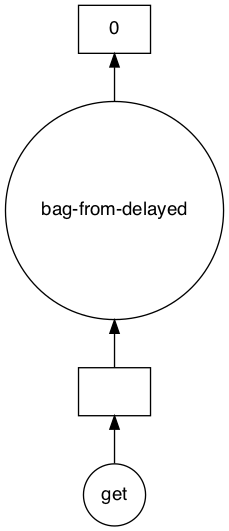

In [6]:
db.from_delayed(results[0]).visualize()

In [7]:
dask_bag = db.from_delayed(results)

The first step is to create a Dask object. There are a few different ways to do this, but since the SODA API returns a json-style sequence, we'll use the Dask Bag collection:

And let's take a look at the first 3 elements:

In [8]:
dask_bag.take(3)

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/Users/sarahj/mambaforge/envs/dask-mini-tutorial/lib/python3.9/site-packages/distributed/protocol/core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/Users/sarahj/mambaforge/envs/dask-mini-tutorial/lib/python3.9/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_

CancelledError: ('take-866cc1dc4627b5bc11a9abcdd4f64ce6', 0)

Dask Bag implements operations like map, filter, and groupby on collections of generic Python objects. It does this in parallel with a small memory footprint using Python iterators (similar a Pythonic version of the PySpark RDD). For data manipulation, though, it can only get us so far. I, for one, would much rather work with pandas than a Python dictionary. That's why we'll now convert the Dask Bag into a Dask DataFrame:

In [ ]:
dask_bag.to_dataframe().head()

Let's put it all together and watch what happens in the dashboard, specifically the workers memory, task stream, and progress tabs (see the [Dashboard Diagnostics page in the Dask documentation](https://docs.dask.org/en/stable/dashboard.html))

In [ ]:
dataset_dict = {
    'downtown': 'avwm-i8ym',
    'fremont': '65db-xm6k',
    'spokane': 'upms-nr8w',
}

with Socrata("data.seattle.gov", socrata_token) as soda_client:
    downtown = get_results(dataset_dict['downtown'])
    fremont = get_results(dataset_dict['fremont'])
    spokane = get_results(dataset_dict['spokane'])

ddf = dd.concat([
    # downtown, 2nd ave dataset
    (db.from_delayed(downtown)
     .to_dataframe()
     .assign(location='downtown')
     .rename(columns={'_2nd_ave_cycletrack': 'total'})
     .drop(['nb', 'sb'], axis=1)),
    # fremont bridge dataset
    (db.from_delayed(fremont)
     .to_dataframe()
     .assign(location='fremont')
     .rename(columns={'fremont_bridge': 'total'})
     .drop(['fremont_bridge_sb', 'fremont_bridge_nb'], axis=1)),
    # spokane street dataset
    (db.from_delayed(spokane)
     .to_dataframe()
     .assign(location='spokane')
     .rename(columns={'spokane_st_bridge_total': 'total'})
     .drop(['west', 'east'], axis=1))
])

ddf['timestamp'] = dd.to_datetime(ddf['date'])

In [ ]:
ddf.compute()

In [ ]:
ddf

In [ ]:
from prophet import Prophet
import prophet.diagnostics

In [ ]:
df.plot(x='timestamp', y='total')

In [ ]:
%%time
m = Prophet(daily_seasonality=False)
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast)

In [ ]:
%%time
df_cv = prophet.diagnostics.cross_validation(
    m, initial="730 days", period="180 days", horizon="365 days",
    parallel="dask"
)

In [ ]:
client.close()